# **Coursework 2 - Group 15**

This project investigates finding an appropriate model for classification and localisation on the Pascal VOC 2012 dataset. 
The dataset available at http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html.
Throughout this project, the team explores the dataset, and applies a machine learning model to classify the image, before determining where in the image and object is.

This project resulted in only single object classification and localisation.

To improve runtime, please use the GPU. Also, update the directory to save the model, which can be located in the cell after model history.

Group Rep: 
  - Kieran Brady - 21120688

Group Members: 
  - Leo Pickett - 
  - Neha Agrawal - 
  - Zak Ison - 
  - Noman Paul - 
  - Yao Li - 
  - Mohana Krishna Battula - 
  - Lakshay Talwar - 


# **Contents:**

  - Loading Pascal VOC 2012 dataset
  - Exploratory Data Analysis
    - Class imbalance
    - Object imbalance
    - Image sizes
    - Annotation positions and sizes
  - Error Analysis
    - Missing images
  - Pre-processing
    - Dataset reduction
    - Class balancing (over and undersampling - class dependent)
    - Testing image augmentations
    - Train / Test Splitting
    - Applying image augmentations to training sample
  - Implmentation
    - Loading pre-trained model
    - Manipulating base model
    - Initialising compiler and metrics
    - Training model
  - Results
    - Visualising model results
    - Preparing test sample set
    - Calculating predictions
    - Visualising predictions

In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Loading raw data**

In [2]:
import os
from pathlib import Path
import urllib.request
import tarfile
dir_name = 'images'
dir_data = Path(f'data/{dir_name}')
dir_model = Path(f'model/{dir_name}')
os.makedirs(dir_model, exist_ok=True)
os.makedirs(dir_data, exist_ok=True)
data_url = 'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar'
download_file = 'data.tar'
urllib.request.urlretrieve(data_url, f'{dir_data/download_file}')
with tarfile.TarFile(dir_data/download_file, 'r') as tar_archive:
        tar_archive.extractall(dir_data)

# **Importing relevant packages / libraries**

In [3]:
######
# Pip installations only required if running on local machine

# Run these in the command prompt
#pip install --upgrade pip  
#pip install jupyter_http_over_ws 
#jupyter serverextension enable --py jupyter_http_over_ws
#jupyter notebook  --NotebookApp.allow_origin='https://colab.research.google.com'  --port=8888  --NotebookApp.port_retries=0
######

# Run these in Colab
#!pip install --upgrade tensorflow
#!pip install --upgrade pandas
#!pip install --upgrade matplotlib
#!pip install --upgrade seaborn
#!pip install --upgrade opencv-python
#!pip install --upgrade sklearn
######
import tensorflow as tf
from tensorflow import keras
import keras.preprocessing.image as image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplt
import seaborn as sns
import PIL
from PIL import Image, ImageDraw,ImageFont, ImageEnhance
import cv2
import math
import xml.etree as et
import xml.etree.ElementTree as ET
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import collections
from collections import Counter
import os
import seaborn as sns
%matplotlib inline

# **Enabling the GPU memory to grow**

In [4]:
# Setting memory growth
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

# **Initialising functions and directories to read the tar file**

In [5]:
img_folder = 'VOCdevkit/VOC2012/JPEGImages'
anno_folder = 'VOCdevkit/VOC2012/Annotations'
cols = ['Name', 'Annotation', 'Image', 'Width', 'Height', 'Object_Qty', 'Label', 'Bound_Box', 'Image_Path']
voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')
label_map = {key: val + 1 for val, key in enumerate(voc_labels)}
print(label_map)

{'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}


In [6]:
def read_annotation(file_name):
    tree = et.ElementTree.parse(file_name)
    root = tree.getroot()

    boxes = []
    labels = []
    difficulties = []

    for item in root.iter('object'):
        difficult = int(item.find('difficult').text == '1')

        label = item.find('name').text.lower().strip()
        if label not in label_map:
            continue

        bbox = item.find('bndbox')
        xmin = int(float(bbox.find('xmin').text)) - 0.1 # To stop stop predictions later going to 0 or 1, i.e. overlap with the edge of the image
        ymin = int(float(bbox.find('ymin').text)) - 0.1
        xmax = int(float(bbox.find('xmax').text)) - 0.1
        ymax = int(float(bbox.find('ymax').text)) - 0.1

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label_map[label])
        difficulties.append(difficult)

    return boxes, labels, difficulties


In [7]:
def read_image_dir(cols, folder):
    file_list = [name[:-4] for name in list(os.listdir(dir_data/folder))]
    image_df = pd.DataFrame(columns=cols)
    image_df['Name'] = file_list
    image_df['Image'] = image_df['Name'] + '.jpg'
    image_df['Annotation'] = image_df['Name'] + '.xml'
    image_df['Image_Path'] = str(dir_data/folder) + '/' + image_df['Image']

    return image_df

In [8]:
def make_image_df(cols, img_path, anno_path):
    image_df = pd.DataFrame(columns=cols)
    image_df = image_df.append(read_image_dir(cols, img_path), ignore_index=True)
    
    for row in range(image_df.shape[0]):
        img_dims = PIL.Image.open(image_df.iloc[row]['Image_Path']).size
        image_df.iloc[row]['Width'] = img_dims[0]
        image_df.iloc[row]['Height'] = img_dims[1]

        img_annos = read_annotation(str(dir_data/anno_path) + '/' + image_df.iloc[row]['Annotation'])
        image_df.iloc[row]['Bound_Box'] = img_annos[0]
        image_df.iloc[row]['Label'] = img_annos[1]
        image_df.iloc[row]['Difficulty'] = img_annos[2]
        image_df.iloc[row]['Object_Qty'] = len(img_annos[1])
    
    return image_df

In [9]:
df = make_image_df(cols, img_path=img_folder, anno_path=anno_folder)
df.head()

Name       Annotation            Image Width Height Object_Qty  \
0  2010_006385  2010_006385.xml  2010_006385.jpg   500    332          1   
1  2009_001350  2009_001350.xml  2009_001350.jpg   403    500          3   
2  2009_000184  2009_000184.xml  2009_000184.jpg   500    375          1   
3  2009_003734  2009_003734.xml  2009_003734.jpg   500    375          2   
4  2010_001271  2010_001271.xml  2010_001271.jpg   500    375          6   

                 Label                                          Bound_Box  \
0                 [15]                       [[51.9, 70.9, 475.9, 331.9]]   
1         [19, 15, 15]  [[59.9, 64.9, 402.9, 408.9], [238.9, 414.9, 24...   
2                 [14]                       [[28.9, 32.9, 482.9, 327.9]]   
3             [13, 15]  [[220.9, 142.9, 396.9, 255.9], [259.9, 85.9, 3...   
4  [11, 9, 9, 9, 9, 9]  [[193.9, 201.9, 369.9, 353.9], [237.9, 209.9, ...   

                                          Image_Path  
0  data/images/VOCdevkit/VOC2012/JPEGImages/2010_...  
1  data/images/VOCdevkit/VOC2012/JPEGImages/2009_...  
2  data/images/VOCdevkit/VOC2012/JPEGImages/2009_...  
3  data/images/VOCdevkit/VOC2012/JPEGImages/2009_...  
4  data/images/VOCdevkit/VOC2012/JPEGImages/2010_...

# **Exploratory Data Analysis**

## **Class Imbalance**

In [10]:
items = []
directory = '/content/data/images/' + anno_folder + '/'
for filename in os.listdir(directory):
  xml_data = open(directory+filename, 'r').read()
  root = ET.XML(xml_data)
  data = []
  cols = []
  for i, child in enumerate(root):
      data.append([subchild.text for subchild in child])
      cols.append(child.tag)

  tmp_arr = [e.text for e in root.findall('object/name')]

  for el in tmp_arr:
    items.append(el)

dfitems = pd.DataFrame(items).rename(columns={0:'counts'})
dfitems = dfitems.groupby(dfitems.columns.tolist(),as_index=False).size()
dfitems

counts   size
0     aeroplane   1002
1       bicycle    837
2          bird   1271
3          boat   1059
4        bottle   1561
5           bus    685
6           car   2492
7           cat   1277
8         chair   3056
9           cow    771
10  diningtable    800
11          dog   1598
12        horse    803
13    motorbike    801
14       person  17401
15  pottedplant   1202
16        sheep   1084
17         sofa    841
18        train    704
19    tvmonitor    893

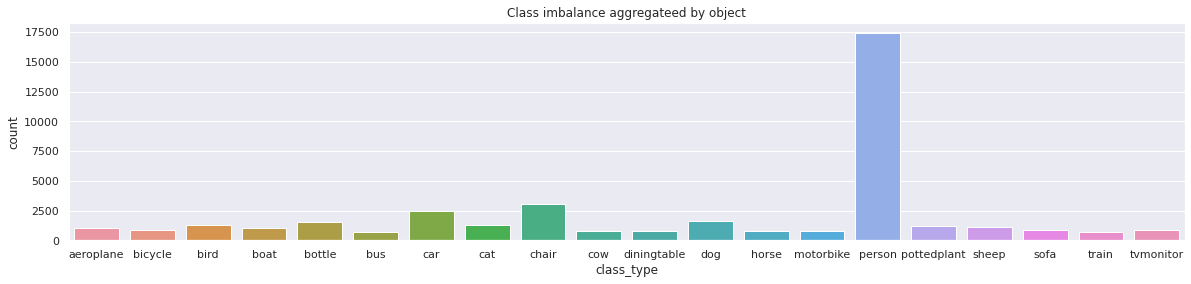

In [11]:
dfitems = dfitems.rename(columns={'counts':'class_type','size':'count'})
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(20,4)})
ax = sns.barplot(x="class_type", y="count", data=dfitems).set_title('Class imbalance aggregateed by object')

## **Object Imbalance**

In [12]:
itemsperimg = []
directory = '/content/data/images/' + anno_folder + '/'
for filename in os.listdir(directory):
  xml_data = open(directory+filename, 'r').read()
  root = ET.XML(xml_data)
  data = []
  cols = []
  for i, child in enumerate(root):
      data.append([subchild.text for subchild in child])
      cols.append(child.tag)

  tmp_arr = [e.text for e in root.findall('object/name')]
  itemsperimg.append(len(tmp_arr))

elements_count = collections.Counter(itemsperimg)
df_elements_count = pd.DataFrame.from_dict(elements_count, orient='index').reset_index()
df_elements_count = df_elements_count.rename(columns={'index':'Objects per image',0:'Number of images'})
#df_elements_count
del elements_count
del itemsperimg

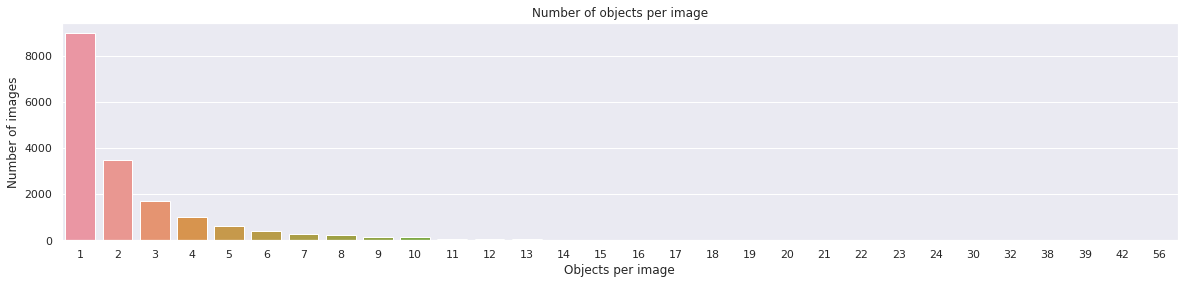

In [13]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(20,4)})
ax = sns.barplot(x="Objects per image", y="Number of images", data=df_elements_count).set_title('Number of objects per image')

## **Distribution of widths & heights**

In [14]:
import os
import numpy as np
dfsizes = []
widths = []
heights = []
depths = []
directory = '/content/data/images/' + anno_folder + '/'
for filename in os.listdir(directory):
  xml_data = open(directory+filename, 'r').read()
  root = ET.XML(xml_data)
  data = []
  cols = []
  for i, child in enumerate(root):
      data.append([subchild.text for subchild in child])
      cols.append(child.tag)

  tmp_width = [e.text for e in root.findall('size/width')]
  if len(tmp_width) > 0:
    widths.append(tmp_width[0])
  tmp_height = [e.text for e in root.findall('size/height')]
  if len(tmp_height) > 0:
    heights.append(tmp_height[0])
  tmp_depth = [e.text for e in root.findall('size/depth')]
  if len(tmp_depth) > 0:
    depths.append(tmp_depth[0])

comb_data = [widths, heights, depths]
comb_data
dfsizes = pd.DataFrame({'Width Sizes (px)': widths, 'Height Sizes (px)' : heights, 'depths': depths}, columns=['Width Sizes (px)', 'Height Sizes (px)','depths'])
dfsizes.head()
del widths
del heights
del depths


Text(0.5, 1.0, 'Number of images vs Widths Sizes')

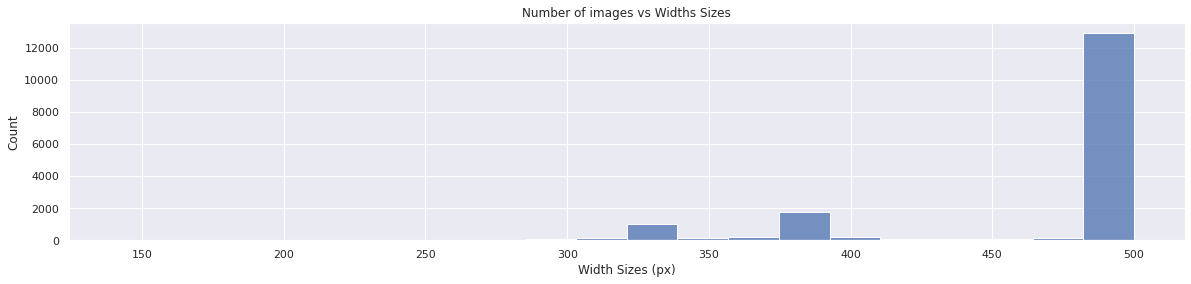

In [15]:
dfsizes.to_csv('/content/images_sizes.csv')
images_sizes = pd.read_csv('/content/images_sizes.csv',index_col=0)
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(20,4)})
sns.histplot(data=images_sizes, x="Width Sizes (px)", bins=20).set_title('Number of images vs Widths Sizes')

Text(0.5, 1.0, 'Number of images vs Height Sizes')

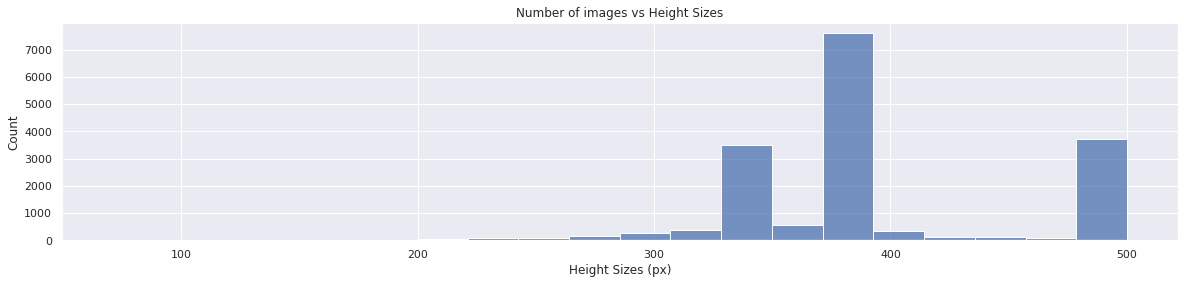

In [16]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(20,4)})
sns.histplot(data=images_sizes, x="Height Sizes (px)", bins=20).set_title('Number of images vs Height Sizes')

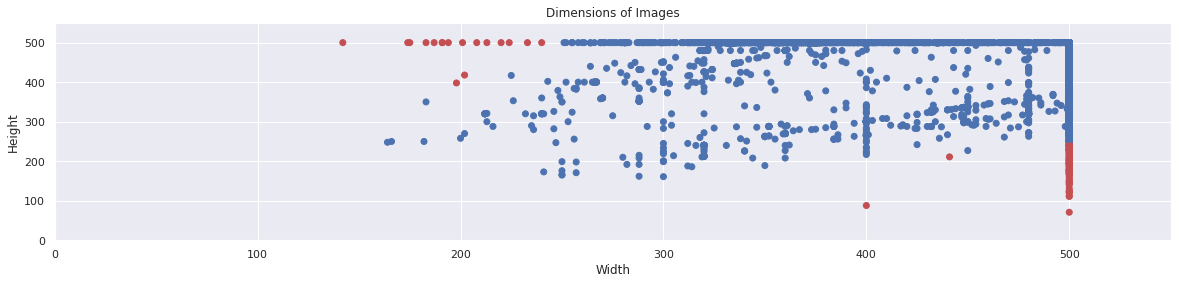

In [17]:
ArrayHeight = np.asarray(images_sizes['Height Sizes (px)'])
ArrayWidth = np.asarray(images_sizes['Width Sizes (px)'])
Ratio = ArrayHeight / ArrayWidth
col = np.where(Ratio<0.5,'r',np.where(Ratio>2,'r','b'))
plt.scatter(images_sizes['Width Sizes (px)'],images_sizes['Height Sizes (px)'], c=col)
plt.xlim(0,550)
plt.ylim(0,550)

plt.title('Dimensions of Images')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()
del ArrayHeight
del ArrayWidth
del Ratio
del images_sizes

## **Distribution of annotation widths & heights & locations within images**

In [18]:
filenames2 = []
xmins = []
xmaxs = []
ymins = []
ymaxs = []
classnames = []
directory = '/content/data/images/' + anno_folder + '/'
for filename in os.listdir(directory):
  filenames = []
  xml_data = open(directory+filename, 'r').read()
  root = ET.XML(xml_data)
  data = []
  cols = []
  for i, child in enumerate(root):
      data.append([subchild.text for subchild in child])
      cols.append(child.tag)

  tmp_arr = [e.text for e in root.findall('filename')]
  for el in tmp_arr:
    filenames.append(el)

  tmp_arr = [e.text for e in root.findall('object/bndbox/xmin')]
  for el in tmp_arr:
    xmins.append(el)
    filenames2.append(filenames[0])    

  tmp_arr = [e.text for e in root.findall('object/bndbox/ymin')]
  for el in tmp_arr:
    ymins.append(el)    

  tmp_arr = [e.text for e in root.findall('object/bndbox/xmax')]
  for el in tmp_arr:
    xmaxs.append(el)

  tmp_arr = [e.text for e in root.findall('object/bndbox/ymax')]
  for el in tmp_arr:
    ymaxs.append(el)

  tmp_arr = [e.text for e in root.findall('object/name')]
  for el in tmp_arr:
    classnames.append(el)

comb_anot_data = [filenames2,xmins, ymins, xmaxs,ymaxs,classnames]
dfAnotsizes = pd.DataFrame({'filenames': filenames2,'xmins': xmins,'ymins': ymins,'xmaxs': xmaxs,'ymaxs': ymaxs,'classnames': classnames}, columns=['filenames','xmins', 'ymins','xmaxs','ymaxs','classnames'])
dfAnotsizes.head()
del filenames2
del xmins
del xmaxs
del ymins
del ymaxs
del classnames

Text(0.5, 1.0, 'Distribution of annotation xmin poisitions')

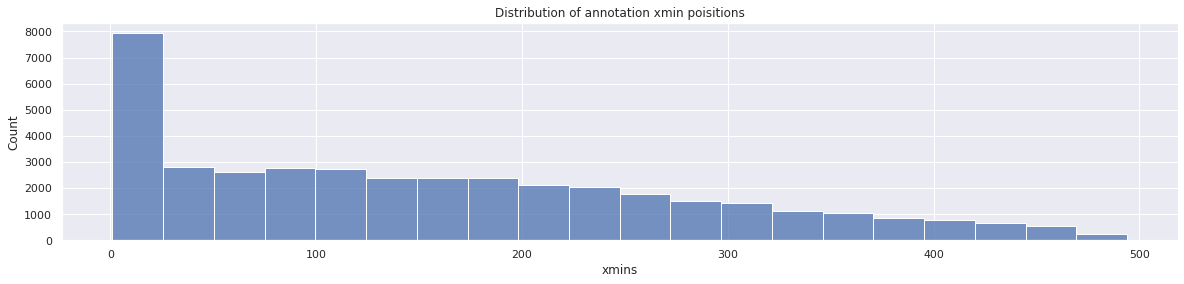

In [19]:
dfAnotsizes.to_csv('/content/annotation_sizes_multiclass.csv')
annotation_sizes = pd.read_csv('/content/annotation_sizes_multiclass.csv',index_col=0)
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(20,4)})
sns.histplot(data=annotation_sizes, x="xmins", bins=20).set_title('Distribution of annotation xmin poisitions')

Text(0.5, 1.0, 'Distribution of annotation xmax poisitions')

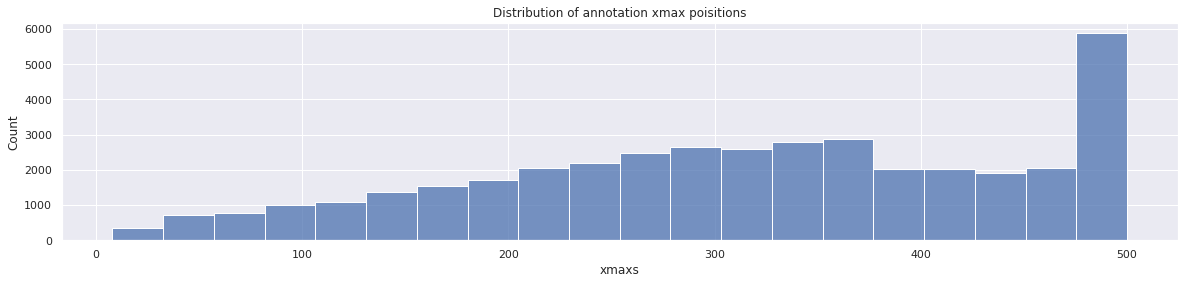

In [20]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(20,4)})
sns.histplot(data=annotation_sizes, x="xmaxs", bins=20).set_title('Distribution of annotation xmax poisitions')

Text(0.5, 1.0, 'Distribution of annotation ymin poisitions')

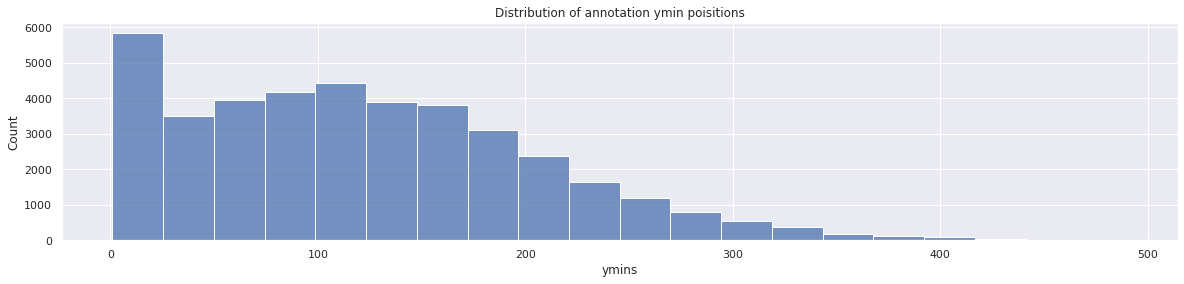

In [21]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(20,4)})
sns.histplot(data=annotation_sizes, x="ymins", bins=20).set_title('Distribution of annotation ymin poisitions')

Text(0.5, 1.0, 'Distribution of annotation ymax poisitions')

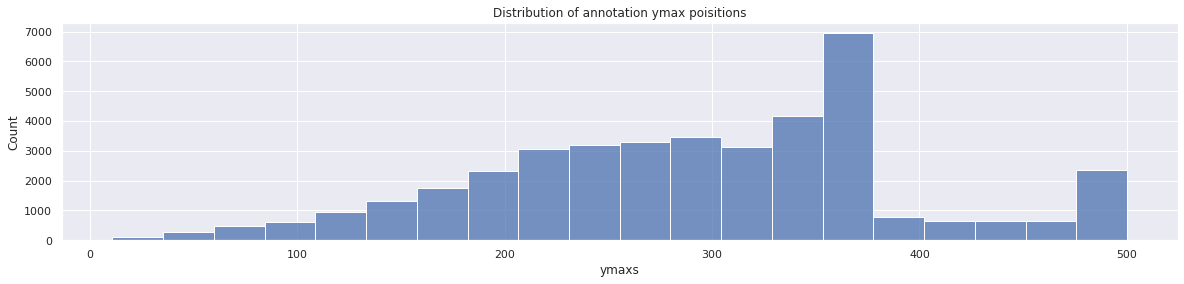

In [22]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(20,4)})
sns.histplot(data=annotation_sizes, x="ymaxs", bins=20).set_title('Distribution of annotation ymax poisitions')

In [23]:
annotation_sizes.head()
for row in range(len(annotation_sizes)):
  width = annotation_sizes.loc[row,'xmaxs'] - annotation_sizes.loc[row,'xmins']
  height = annotation_sizes.loc[row,'ymaxs'] - annotation_sizes.loc[row,'ymins']
  annotation_sizes.at[row,'width'] = width
  annotation_sizes.at[row,'height'] = height
  annotation_sizes.at[row,'size'] = width*height

Text(0.5, 1.0, 'Distribution of annotation sizes')

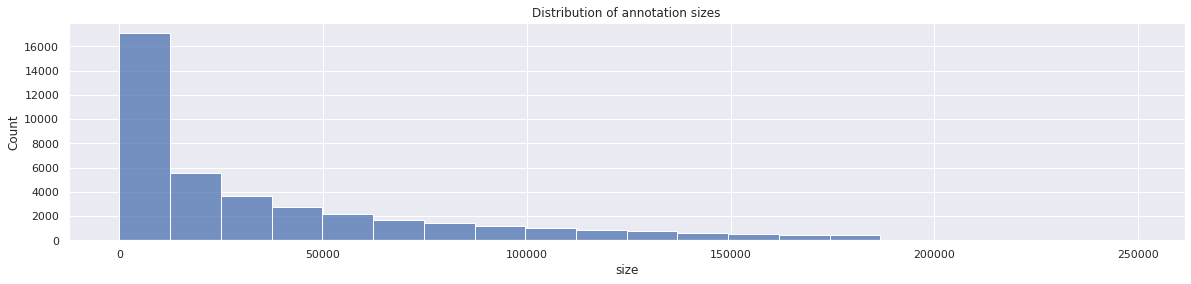

In [24]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(20,4)})
sns.histplot(data=annotation_sizes, x="size", bins=20).set_title('Distribution of annotation sizes')

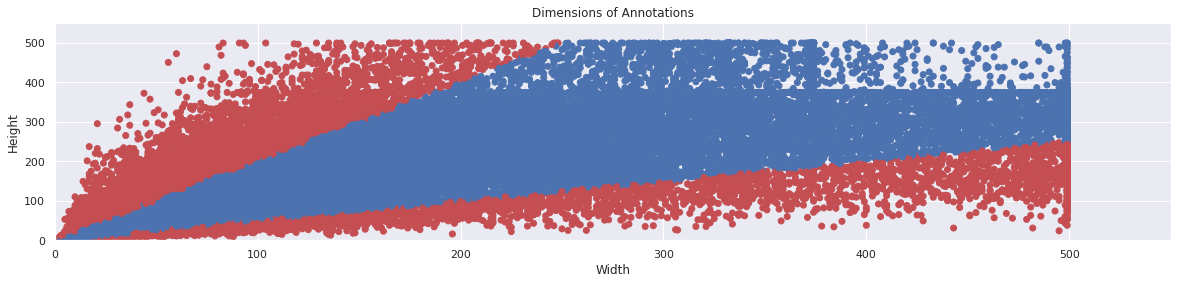

In [25]:
annotation_sizes.head()

ArrayHeight = np.asarray(annotation_sizes['height'])
ArrayWidth = np.asarray(annotation_sizes['width'])
Ratio = ArrayHeight / ArrayWidth
col = np.where(Ratio<0.5,'r',np.where(Ratio>2,'r','b'))
plt.scatter(annotation_sizes['width'],annotation_sizes['height'], c=col)
plt.xlim(0,550)
plt.ylim(0,550)

plt.title('Dimensions of Annotations')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

In [26]:
del dfitems
del df_elements_count
del dfsizes
del dfAnotsizes
del annotation_sizes

# **Error Analysis**

In [27]:
directory1 = '/content/data/images/' + anno_folder + '/'
directory2 = '/content/data/images/' + img_folder + '/'

JPEGImages = []
Annotations = []

for file in os.listdir(directory1):
    filename = os.fsdecode(file)
    JPEGImages.append(filename[:-4])

for file in os.listdir(directory2):
    filename = os.fsdecode(file)
    Annotations.append(filename[:-4])      

Total = JPEGImages + Annotations

Missing = {key: value for key, value in collections.Counter(Total).items() if value < 2}
MissingList = list(Missing.keys())
print(MissingList)
print('Number of missing items:', len(MissingList))
del JPEGImages
del Annotations

[]
Number of missing items: 0


# **Preprocessing**

## **Data Reduction**
  - Selecting only single object images

In [28]:
df2 = df[df['Object_Qty'] == 1]
df2 = df2.reset_index(drop=True)
df2.head()

Name       Annotation            Image Width Height Object_Qty  \
0  2010_006385  2010_006385.xml  2010_006385.jpg   500    332          1   
1  2009_000184  2009_000184.xml  2009_000184.jpg   500    375          1   
2  2011_006706  2011_006706.xml  2011_006706.jpg   500    375          1   
3  2009_004370  2009_004370.xml  2009_004370.jpg   500    374          1   
4  2012_002905  2012_002905.xml  2012_002905.jpg   500    375          1   

  Label                      Bound_Box  \
0  [15]   [[51.9, 70.9, 475.9, 331.9]]   
1  [14]   [[28.9, 32.9, 482.9, 327.9]]   
2  [15]   [[81.9, 62.9, 142.9, 233.9]]   
3   [7]    [[0.9, 47.9, 499.9, 203.9]]   
4  [15]  [[106.9, 14.9, 384.9, 374.9]]   

                                          Image_Path  
0  data/images/VOCdevkit/VOC2012/JPEGImages/2010_...  
1  data/images/VOCdevkit/VOC2012/JPEGImages/2009_...  
2  data/images/VOCdevkit/VOC2012/JPEGImages/2011_...  
3  data/images/VOCdevkit/VOC2012/JPEGImages/2009_...  
4  data/images/VOCdevkit/VOC2012/JPEGImages/2012_...

## **Removing outer array brackets for the label and bounding box columns**

In [29]:
del df
for row in range(len(df2)):
  df2['Label'][row] = df2.loc[row,'Label'][0]
  df2['Bound_Box'][row] = df2.loc[row,'Bound_Box'][0]

df2.head()  

Name       Annotation            Image Width Height Object_Qty  \
0  2010_006385  2010_006385.xml  2010_006385.jpg   500    332          1   
1  2009_000184  2009_000184.xml  2009_000184.jpg   500    375          1   
2  2011_006706  2011_006706.xml  2011_006706.jpg   500    375          1   
3  2009_004370  2009_004370.xml  2009_004370.jpg   500    374          1   
4  2012_002905  2012_002905.xml  2012_002905.jpg   500    375          1   

  Label                    Bound_Box  \
0    15   [51.9, 70.9, 475.9, 331.9]   
1    14   [28.9, 32.9, 482.9, 327.9]   
2    15   [81.9, 62.9, 142.9, 233.9]   
3     7    [0.9, 47.9, 499.9, 203.9]   
4    15  [106.9, 14.9, 384.9, 374.9]   

                                          Image_Path  
0  data/images/VOCdevkit/VOC2012/JPEGImages/2010_...  
1  data/images/VOCdevkit/VOC2012/JPEGImages/2009_...  
2  data/images/VOCdevkit/VOC2012/JPEGImages/2011_...  
3  data/images/VOCdevkit/VOC2012/JPEGImages/2009_...  
4  data/images/VOCdevkit/VOC2012/JPEGImages/2012_...

## **Class imbalance before balancing**

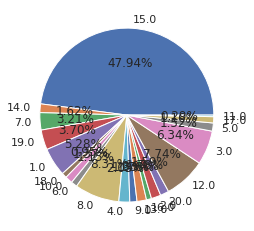

In [30]:
labels_arr = df2['Label']
cnt = Counter(labels_arr)
plt.pie([float(v) for v in cnt.values()], labels=[float(k) for k in cnt],autopct='%1.2f%%')
plt.show()
del labels_arr

## **Choosing to randomly sample 400 images for each class type, and where there isn't atleast 400 images, then randomly oversampling those classes without replacement (400 was chosen only because any more than 400 caused RAM issues in Colab)**

In [31]:
# Balancing the class types
val_counts_df = df2['Label'].value_counts().rename_axis('unique_values').reset_index(name='counts')

img_sample_size = 400
df3 = df2.copy()

for row in range(len(val_counts_df)):
  df2_temp = []
  if val_counts_df.loc[row,'counts'] > img_sample_size:
    df2_temp = df2[df2['Label'] == val_counts_df.loc[row,'unique_values']].sample(n=img_sample_size)
    df3 = df3[df3['Label'] != val_counts_df.loc[row,'unique_values']]
    df3 = df3.append(df2_temp, ignore_index=True).reset_index(drop=True)
  else:
    img_to_process = img_sample_size - val_counts_df.loc[row,'counts']
    df2_temp = df2[df2['Label'] == val_counts_df.loc[row,'unique_values']].sample(n=img_to_process, replace=True)
    df3 = df3.append(df2_temp, ignore_index=True).reset_index(drop=True)

df3['Label'].value_counts()   
del val_counts_df 

## **Shuffling the dataframe before image augmentations**

In [32]:
from sklearn.utils import shuffle
df3 = shuffle(df3).reset_index(drop=True)
df3.head()

Name       Annotation            Image Width Height Object_Qty  \
0  2010_003816  2010_003816.xml  2010_003816.jpg   500    192          1   
1  2011_002062  2011_002062.xml  2011_002062.jpg   500    336          1   
2  2010_003954  2010_003954.xml  2010_003954.jpg   500    319          1   
3  2008_007748  2008_007748.xml  2008_007748.jpg   500    377          1   
4  2010_000747  2010_000747.xml  2010_000747.jpg   500    325          1   

  Label                     Bound_Box  \
0     1     [3.9, 26.9, 497.9, 154.9]   
1    14    [114.9, 0.9, 483.9, 311.9]   
2    17    [22.9, 80.9, 288.9, 306.9]   
3     4  [190.9, 200.9, 249.9, 221.9]   
4     2    [4.9, 132.9, 204.9, 311.9]   

                                          Image_Path  
0  data/images/VOCdevkit/VOC2012/JPEGImages/2010_...  
1  data/images/VOCdevkit/VOC2012/JPEGImages/2011_...  
2  data/images/VOCdevkit/VOC2012/JPEGImages/2010_...  
3  data/images/VOCdevkit/VOC2012/JPEGImages/2008_...  
4  data/images/VOCdevkit/VOC2012/JPEGImages/2010_...

## **Class imbalancing after balancing method applied**

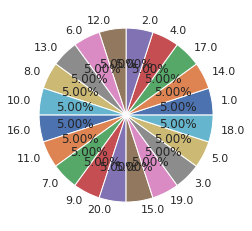

In [33]:
labels_arr = df3['Label']
cnt = Counter(labels_arr)
plt.pie([float(v) for v in cnt.values()], labels=[float(k) for k in cnt],autopct='%1.2f%%')
plt.show()
del labels_arr

## **Splitting the data in train and test sets**

In [34]:
trainMax = round(len(df3) * 0.8)
train_df = df3[0:trainMax].reset_index(drop=True)
test_df = df3[trainMax:].reset_index(drop=True)
train_df.shape, test_df.shape

((6400, 9), (1600, 9))

## **Calculating whole dataset mean colour**

In [35]:
img_size = 224
sum = np.array([0.0, 0.0, 0.0]);
count = 0
i = 0
for image in range(len(df2)):
  im = cv2.imread(df2.loc[image,'Image_Path']) * 255.0
  resized_image = cv2.resize(im, (img_size,img_size)) 
  count += resized_image.shape[0]
  #print(resized_image)
  sum += np.sum(resized_image, axis=(0, 1))
  #i += 1
  #if i > 0:
    #break
#print(sum)     
dataset_avg = sum/(count*224*224)
print(dataset_avg) 

[117.06091663 126.23483338 131.55701178]


## **Calculating train sample set mean colour**

In [36]:
sum = np.array([0.0, 0.0, 0.0]);
count = 0
i = 0
for image in range(len(train_df)):
  im = cv2.imread(train_df.loc[image,'Image_Path']) * 255.0
  resized_image = cv2.resize(im, (img_size,img_size)) 
  count += resized_image.shape[0]
  #print(resized_image)
  sum += np.sum(resized_image, axis=(0, 1))
  #i += 1
  #if i > 0:
    #break
#print(sum)     
train_df_avg = sum/(count*img_size*img_size)
print(train_df_avg) 
del df2
del df3

[117.94728766 129.23099776 134.24008081]


## **Testing image augmentations**

 - Rotations
 - Flipping (vertically and horizontally)
 - Increasing and decreasing brightness
 - Sharpening
 - Altering colour skew 


### **Image to test augmentations on**

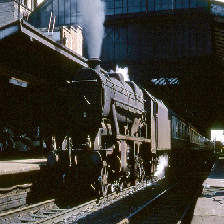

In [38]:
import keras.preprocessing.image as image
pred_img = image.load_img(train_df.loc[0,'Image_Path'], target_size=(img_size, img_size))
pred_img

### **Rotating the test image**

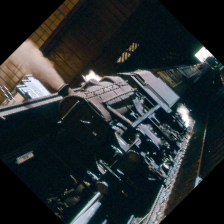

In [39]:
# Rotated image
im = cv2.imread(train_df.loc[0,'Image_Path'])
resized_image = cv2.resize(im, (img_size,img_size))
# dividing height and width by 2 to get the center of the image
height, width = resized_image.shape[:2]
# get the center coordinates of the image to create the 2D rotation matrix
center = (width/2, height/2)
# using cv2.getRotationMatrix2D() to get the rotation matrix
rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=45, scale=1)
# rotate the image using cv2.warpAffine
rotated_image = cv2.warpAffine(src=resized_image, M=rotate_matrix, dsize=(width, height))
pil_img = tf.keras.preprocessing.image.array_to_img(rotated_image)
pil_img

### **Increasing the brightness on the test image**

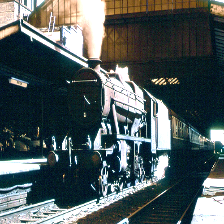

In [41]:
# Increasing Brightness
im = cv2.imread(train_df.loc[0,'Image_Path'])
resized_image = cv2.resize(im, (img_size,img_size))
mat = np.ones(resized_image.shape,dtype = 'uint8')*100
brighter = cv2.add(resized_image,mat)
pil_img = tf.keras.preprocessing.image.array_to_img(brighter)
pil_img

### **Decreasing the brightness on the test image**

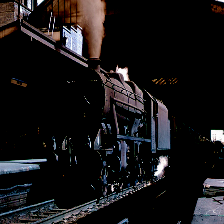

In [42]:
# Decreasing Brightness
im = cv2.imread(train_df.loc[0,'Image_Path'])
resized_image = cv2.resize(im, (img_size,img_size))
mat = np.ones(resized_image.shape,dtype = 'uint8')*100
darker = cv2.subtract(resized_image,mat)
pil_img = tf.keras.preprocessing.image.array_to_img(darker)
pil_img

### **Flipping the test image**

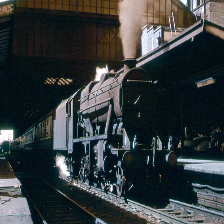

In [45]:
# Flipping image - flipcode = 0: flip vertically, flipcode > 0: flip horizontally, flipcode < 0: flip vertically and horizontally
flipcode = 1
im = cv2.imread(train_df.loc[0,'Image_Path'])
resized_image = cv2.resize(im, (img_size,img_size))
flip = cv2.flip(resized_image,flipcode)
pil_img = tf.keras.preprocessing.image.array_to_img(flip)
pil_img

### **Sharpening the test image**

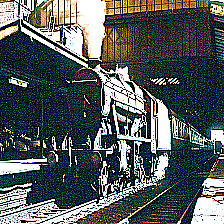

In [47]:
# Sharpening Image
im = cv2.imread(train_df.loc[0,'Image_Path'])
resized_image = cv2.resize(im, (img_size,img_size))
sharpening = np.array([[-1,-1,-1],
                       [-1,10,-1],
                       [-1,-1,-1]])
sharpened = cv2.filter2D(resized_image,-1,sharpening)
pil_img = tf.keras.preprocessing.image.array_to_img(sharpened)
pil_img

### **Altering the colour skew**

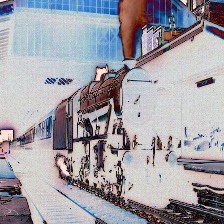

In [46]:
# Subtracting the mean RGB value
im = cv2.imread(train_df.loc[0,'Image_Path'])
resized_image = cv2.resize(im, (img_size,img_size)) 
flip = cv2.flip(resized_image,1)
subtracted_RGB_img = np.absolute(flip - train_df_avg)
subtracted_RGB_img = subtracted_RGB_img.astype(np.uint8)
pil_img = tf.keras.preprocessing.image.array_to_img(subtracted_RGB_img)
pil_img

## **Applying the image augmentations to the train sample set and scaling the bounding boxes**

Two augmentations were selected:
 - Removing the mean colour of the train set from each train image, for data reduction
 - Horizonatally flipping images, to reduce overfitting due to the over sampling class balance method

In [ ]:
x_train = []
y_train = []
boxes_bb = []
img_size = 224

for image1 in range(len(train_df)):
  label = [train_df.loc[image1,'Label']]

  # Original image
  im = cv2.imread(train_df.loc[image1,'Image_Path']) 
  x_scale = img_size / train_df.loc[image1,'Width']
  y_scale = img_size / train_df.loc[image1,'Height']
  resized_image = cv2.resize(im, (img_size,img_size)) 

  # Rescaling the boxes
  xmin_sacled = train_df.loc[image1,'Bound_Box'][0] * x_scale
  ymin_sacled = train_df.loc[image1,'Bound_Box'][1] * y_scale
  xmax_sacled = train_df.loc[image1,'Bound_Box'][2] * x_scale
  ymax_sacled = train_df.loc[image1,'Bound_Box'][3] * y_scale

  # Subtracting the mean RGB value
  subtracted_RGB_img = np.absolute(resized_image - train_df_avg)
  subtracted_RGB_img = subtracted_RGB_img.astype(np.uint8)

  # Flipping every other image to reduce overfitting from up sampling the class types
  if image1 % 2 == 0:
    x_train.append(subtracted_RGB_img)
    y_train.append(label)
    boxes_bb.append([xmin_sacled,ymin_sacled,xmax_sacled,ymax_sacled])
  else:
    # Flipping image - flipcode = 0: flip vertically, flipcode > 0: flip horizontally, flipcode < 0: flip vertically and horizontally
    flip = cv2.flip(subtracted_RGB_img,1)
    x_train.append(flip)
    y_train.append(label)
    boxes_bb.append([img_size - xmax_sacled,ymin_sacled,img_size - xmin_sacled,ymax_sacled])

x_train = np.asarray(x_train).astype('float32')#/255
#print(len(x_train))  
y_train = np.asarray(y_train).astype('float32')
boxes_bb = np.asarray(boxes_bb).astype('float32')/img_size
#y_train = np.concatenate([y_train,boxes], axis=1)
trainTargets = {
    "label": y_train,
    "bbox": boxes_bb
}
print(x_train.shape)
print(y_train.shape)
print(boxes_bb.shape)

(6400, 224, 224, 3)
(6400, 1)
(6400, 4)


In [ ]:
trainTargets

{'bbox': array([[1.8000000e-03, 2.3999999e-03, 9.9980003e-01, 9.9973333e-01],
        [2.6019999e-01, 4.1040000e-01, 7.2219998e-01, 7.8373331e-01],
        [1.5380000e-01, 3.9733332e-02, 7.8779995e-01, 9.9706662e-01],
        ...,
        [5.6200001e-02, 2.5040001e-01, 8.8219994e-01, 7.1973330e-01],
        [2.4980000e-01, 4.7733333e-02, 8.7779999e-01, 6.5040004e-01],
        [1.9999999e-04, 2.0996440e-02, 9.9820000e-01, 9.9964416e-01]],
       dtype=float32), 'label': array([[ 7.],
        [10.],
        [12.],
        ...,
        [17.],
        [12.],
        [11.]], dtype=float32)}

## **Checking that the bounding boxes are in the correct location after being scaled**

[0.2602    0.4104    0.7222    0.7837333]
[138.9, 153.9, 369.9, 293.9]
500
375


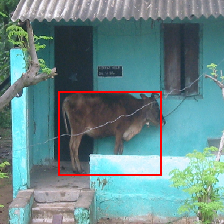

In [ ]:
# Real box
image_number = 1
print(trainTargets['bbox'][image_number])
print(train_df.loc[image_number,'Bound_Box'])
print(train_df.loc[image_number,'Width'])
print(train_df.loc[image_number,'Height'])
xmin = 0
xmax = 0
xmin = img_size * trainTargets['bbox'][image_number][0]
ymin = img_size * trainTargets['bbox'][image_number][1]
xmax = img_size * trainTargets['bbox'][image_number][2]
ymax = img_size * trainTargets['bbox'][image_number][3]

import keras.preprocessing.image as image
pred_img = image.load_img(train_df.loc[image_number,'Image_Path'], target_size=(img_size, img_size))
import math
from PIL import Image, ImageDraw
img = pred_img
rimg = img.copy()
rimg_draw = ImageDraw.Draw(rimg)
rimg_draw.rectangle((xmin, ymin, xmax, ymax), fill=None, outline=(255,0, 0),width=2) # predicted bounding box
rimg

In [ ]:
print(y_train)

[[ 7.]
 [10.]
 [12.]
 ...
 [17.]
 [12.]
 [11.]]


## **Checking image augmentations have been applied correctly to the training sample set**

[[ 7.]
 [10.]
 [12.]
 [19.]
 [19.]
 [ 3.]
 [17.]
 [20.]
 [ 9.]
 [13.]]


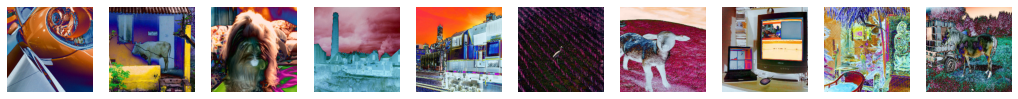

In [ ]:
fig = plt.figure(figsize=(18,18))
for imgs in range(10):
  img = pil_img = tf.keras.preprocessing.image.array_to_img(x_train[imgs])
  plt.subplot(1,10,imgs+1)
  plt.axis('off')
  plt.imshow(img)
print(y_train[:10])  

# **Implementation**

## **Loading a vgg19 pre trained model**

In [ ]:
vgg19_model = tf.keras.applications.vgg19.VGG19()
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## **Adjusting the model architecture to suit the dataset and also creating additional layers to train bounding boxes in parallel with the classification outputs**

In [ ]:
for layer in vgg19_model.layers:
  layer.trainable = False

inputs = vgg19_model.input
x = vgg19_model.layers[-2].output
classifier_head = keras.layers.Dropout(0.3)(x)
classifier_head = keras.layers.Dense(21, activation='softmax', name='label')(classifier_head)
reg_head = keras.layers.Dense(128, activation='relu')(x)
reg_head = keras.layers.Dense(64, activation='relu')(reg_head)
reg_head = keras.layers.Dense(32, activation='relu')(reg_head)
reg_head = keras.layers.Dense(4, activation='sigmoid', name='bbox')(reg_head)
model_pre_trained = keras.models.Model(inputs=[inputs], outputs=[classifier_head, reg_head])
model_pre_trained.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

## **Initialising metrics and early stopping**

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, restore_best_weights=True)
opt = keras.optimizers.Adam(learning_rate=0.001)
losses = {"label":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), "bbox":tf.keras.losses.MSE}
loss_weights = {'label': 1.0,'bbox': 1.0}
metrics = {'label': ["accuracy"],'bbox': [tf.keras.metrics.MeanIoU(num_classes=20)]}
model_pre_trained.compile(loss =losses,loss_weights=loss_weights, optimizer=opt, metrics = metrics)

## **Training the model**

In [ ]:
history = model_pre_trained.fit(x_train.reshape((x_train.shape[0], img_size, img_size, 3)),trainTargets, epochs = 20,batch_size=40,validation_split=0.1, shuffle=True, callbacks=[early_stopping_cb],verbose=2)

Epoch 1/20
144/144 - 54s - loss: 1.2645 - label_loss: 1.2272 - bbox_loss: 0.0373 - label_accuracy: 0.6585 - bbox_mean_io_u: 0.4888 - val_loss: 0.8138 - val_label_loss: 0.7943 - val_bbox_loss: 0.0195 - val_label_accuracy: 0.7828 - val_bbox_mean_io_u: 1.0000 - 54s/epoch - 378ms/step
Epoch 2/20
144/144 - 40s - loss: 0.5400 - label_loss: 0.5220 - bbox_loss: 0.0180 - label_accuracy: 0.8378 - bbox_mean_io_u: 1.0000 - val_loss: 0.6676 - val_label_loss: 0.6522 - val_bbox_loss: 0.0154 - val_label_accuracy: 0.8297 - val_bbox_mean_io_u: 1.0000 - 40s/epoch - 280ms/step
Epoch 3/20
144/144 - 42s - loss: 0.3598 - label_loss: 0.3456 - bbox_loss: 0.0142 - label_accuracy: 0.8927 - bbox_mean_io_u: 1.0000 - val_loss: 0.6155 - val_label_loss: 0.6005 - val_bbox_loss: 0.0150 - val_label_accuracy: 0.8562 - val_bbox_mean_io_u: 1.0000 - 42s/epoch - 293ms/step
Epoch 4/20
144/144 - 43s - loss: 0.2671 - label_loss: 0.2550 - bbox_loss: 0.0120 - label_accuracy: 0.9181 - bbox_mean_io_u: 1.0000 - val_loss: 0.5865 - va

## **Saving the model locally**

In [35]:
# Load and save model
#model_pre_trained.save('/content/gdrive/MyDrive/personal stuff/Cardiff University/CMT307 - Machine Learning/Spring Semester/Coursework 2/cw_models/11_04_22_10_00')
#model_pre_trained = keras.models.load_model('/content/gdrive/MyDrive/personal stuff/Cardiff University/CMT307 - Machine Learning/Spring Semester/Coursework 2/cw_models/10_04_22_16_00')

# **Results**

## **Visualising the model accuracy and loss**

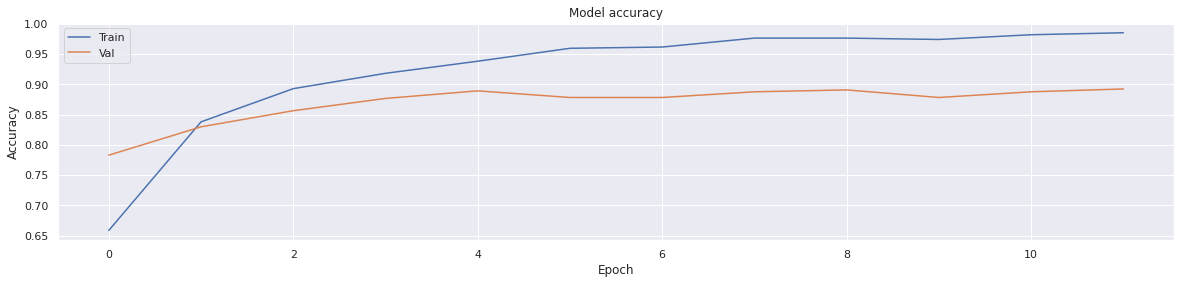

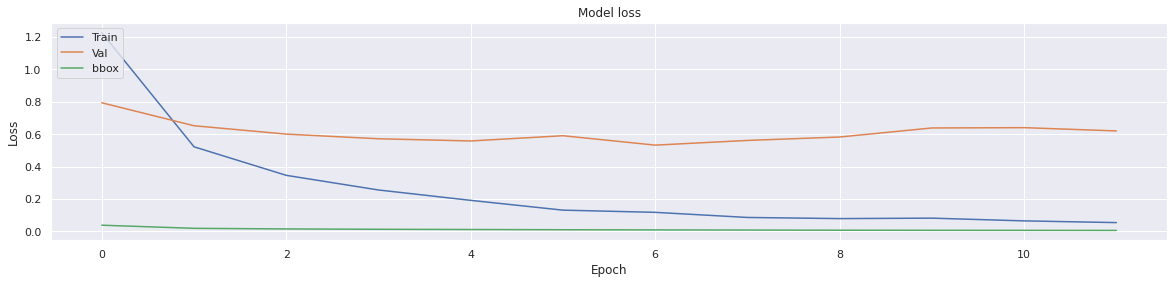

In [ ]:
# Visualise loss/accuracy during training
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['label_accuracy'])
plt.plot(history.history['val_label_accuracy'])
#plt.plot(history.history['bbox_mean_io_u_1'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val','bbox'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['label_loss'])
plt.plot(history.history['val_label_loss'])
plt.plot(history.history['bbox_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val','bbox'], loc='upper left')
plt.show()

## **Preparing the test sample set**

In [36]:
x_test = []
y_test = []
test_boxes = []
img_size = 224
for image in range(len(test_df)):
  label = [test_df.loc[image,'Label']]

  # Original image
  im = cv2.imread(test_df.loc[image,'Image_Path']) 
  test_x_scale = img_size / im.shape[1]
  test_y_scale = img_size / im.shape[0]
  resized_image = cv2.resize(im, (img_size,img_size)) 
  x_test.append(resized_image)
  y_test.append(label)

  # Rescaling the boxes
  test_xmin_sacled = test_df.loc[image,'Bound_Box'][0] * test_x_scale
  test_ymin_sacled = test_df.loc[image,'Bound_Box'][1] * test_y_scale
  test_xmax_sacled = test_df.loc[image,'Bound_Box'][2] * test_x_scale
  test_ymax_sacled = test_df.loc[image,'Bound_Box'][3] * test_y_scale
  test_boxes.append([test_xmin_sacled,test_ymin_sacled,test_xmax_sacled,test_ymax_sacled])

x_test = np.asarray(x_test).astype('float32')#/255
#print(len(x_test))  
y_test = np.asarray(y_test).astype('float32')
test_boxes = np.asarray(test_boxes).astype('float32')/img_size
#y_train = np.concatenate([y_test,test_boxes], axis=1)
testTargets = {
    "label": y_test,
    "bbox": test_boxes
}
print(x_test.shape)
print(y_test.shape)
print(test_boxes.shape)

(1600, 224, 224, 3)
(1600, 1)
(1600, 4)


In [37]:
testTargets['bbox']

array([[0.0024    , 0.7278    , 0.9997333 , 0.9998    ],
       [0.2178    , 0.8717333 , 0.99380004, 0.9997333 ],
       [0.0038    , 0.10527778, 0.9818    , 0.9997222 ],
       ...,
       [0.45727274, 0.25980002, 0.9693939 , 0.9998    ],
       [0.4558    , 0.00243243, 0.9998    , 0.9997297 ],
       [0.0758    , 0.20503876, 0.9698    , 0.7360465 ]], dtype=float32)

## **Evaluating the model on the test set**

In [44]:
model_pre_trained.evaluate(x_test, testTargets)

50/50 [==============================] - 18s 362ms/step - loss: 0.6863 - label_loss: 0.6652 - bbox_loss: 0.0211 - label_accuracy: 0.8400 - bbox_mean_io_u: 1.0000


[0.6862713694572449,
 0.6651658415794373,
 0.021105458959937096,
 0.8399999737739563,
 1.0]

## **Generating and visualising the predictions**

In [45]:
predictions = model_pre_trained.predict(x=x_test,verbose=0)

In [46]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
predictions[1]

array([[7.36784115e-02, 1.67233676e-01, 9.15489852e-01, 9.40239906e-01],
       [2.95792371e-01, 5.65659642e-01, 9.22372818e-01, 9.18408155e-01],
       [3.66140790e-02, 1.12672545e-01, 8.56696367e-01, 9.54212070e-01],
       [5.59959471e-01, 4.44939584e-02, 5.94070494e-01, 9.78915632e-01],
       [6.90650716e-02, 8.19357783e-02, 8.40770543e-01, 9.01241302e-01],
       [3.72483209e-03, 1.72789663e-01, 9.89147663e-01, 9.99685407e-01],
       [2.09445916e-02, 1.59869477e-01, 9.73636448e-01, 8.00604463e-01],
       [2.65808403e-02, 1.77564640e-02, 9.73401546e-01, 9.94146228e-01],
       [1.91830382e-01, 5.42134225e-01, 9.28559661e-01, 8.38865936e-01],
       [6.70936599e-04, 6.62905723e-03, 9.89104748e-01, 9.97471452e-01],
       [2.48363659e-01, 2.62066424e-01, 8.06431770e-01, 9.65686083e-01],
       [4.66258591e-03, 1.82285700e-02, 9.96430337e-01, 9.39649582e-01],
       [2.30061725e-01, 1.01037785e-01, 9.26977098e-01, 9.37714577e-01],
       [1.00255780e-01, 3.60132568e-02, 9.75095570e

## **Visualising the predictions using the images**

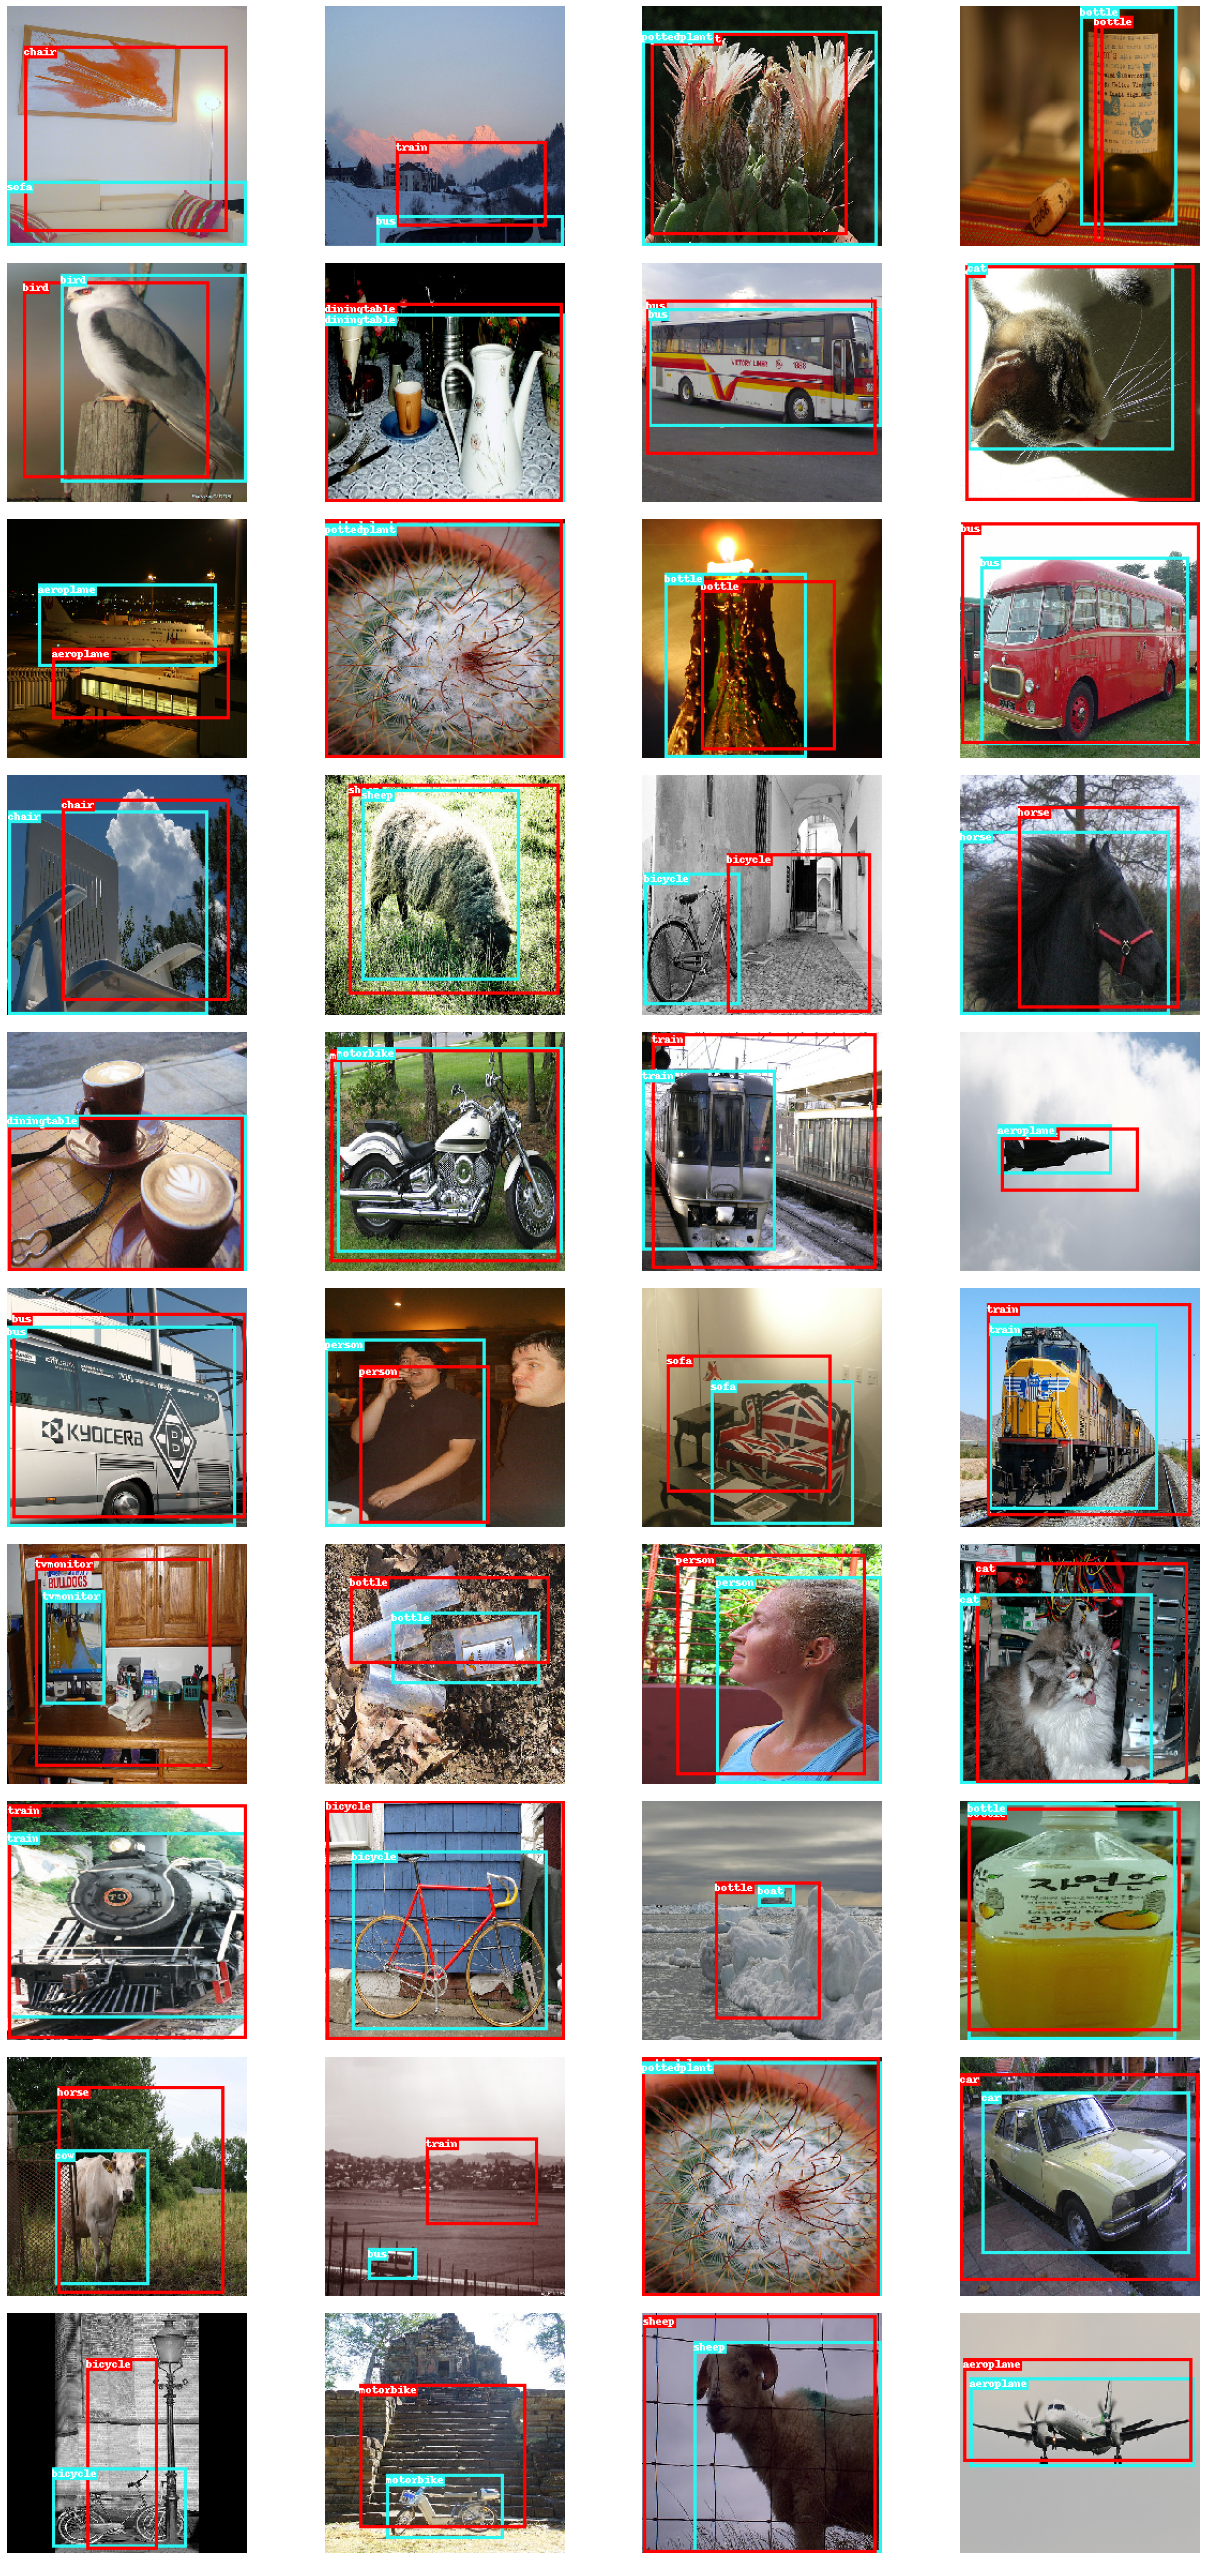

In [47]:
import keras.preprocessing.image as image
fig = plt.figure(figsize=(18,36))
for image_number in range(40):
  w = 0
  h = 0
  w2 = 0
  h2 = 0
  pred_img = image.load_img(test_df.loc[image_number,'Image_Path'], target_size=(img_size, img_size))

  result = np.where(predictions[0][image_number] == predictions[0][image_number].max())
  #print(predictions[0][image_number])
  #print('predicted label:',voc_labels[result[0][0]-1])
  #print(test_df.loc[image_number,'Bound_Box'])
  #print('actual label:',voc_labels[int(test_df.loc[image_number,'Label'])-1])
  #print(test_df.loc[image_number,'Image'])

  # Real box
  im = cv2.imread(test_df.loc[image_number,'Image_Path'])
  real_x_scale = img_size / im.shape[1]
  real_y_scale = img_size / im.shape[0]
  real_xmin_sacled = test_df.loc[image_number,'Bound_Box'][0] * real_x_scale
  real_ymin_sacled = test_df.loc[image_number,'Bound_Box'][1] * real_y_scale
  real_xmax_sacled = test_df.loc[image_number,'Bound_Box'][2] * real_x_scale
  real_ymax_sacled = test_df.loc[image_number,'Bound_Box'][3] * real_y_scale

  box_preds = predictions[1][image_number]
  #print(box_preds)
  xmin = img_size * box_preds[0]
  ymin = img_size * box_preds[1]
  xmax = img_size * box_preds[2]
  ymax = img_size * box_preds[3]

  import math
  from PIL import Image, ImageDraw
  font = ImageFont.load_default()
  img = pred_img
  rimg = img.copy()
  rimg_draw = ImageDraw.Draw(rimg)
  rimg_draw.rectangle((real_xmin_sacled,real_ymin_sacled,real_xmax_sacled,real_ymax_sacled), fill=None, outline=(42, 245, 241),width=3) # correct box
  rimg_draw.rectangle((xmin, ymin, xmax, ymax), fill=None, outline=(255,0, 0),width=3) # predicted bounding box #42, 245, 241 0, 128, 0
  text = voc_labels[result[0][0]-1]
  w, h = font.getsize(text)
  rimg_draw.rectangle((xmin,ymin+h, xmin+w, ymin), fill=(255,0, 0))
  rimg_draw.text((xmin,ymin), text)
  text2 = voc_labels[int(test_df.loc[image_number,'Label'])-1]
  w2, h2 = font.getsize(text2)
  rimg_draw.rectangle((real_xmin_sacled,real_ymin_sacled+h2, real_xmin_sacled+w2, real_ymin_sacled), fill=(42, 245, 241))
  rimg_draw.text((real_xmin_sacled,real_ymin_sacled), text2)
#rimg
  plt.subplot(10,4,image_number+1)
  plt.tight_layout()
  plt.axis('off')
  plt.imshow(rimg)
#print(y_train[:10]) 